In [3]:
import numpy as np
from tqdm import tqdm
import cv2
import os
import tensorflow as tf

In [4]:
home_dir="UTKFace"
Images=[]
Ag=[]
for filename in tqdm(os.listdir(home_dir)):
    image_path=os.path.join(home_dir,filename)
    temp=filename.split("_")
    age=int(temp[0])
    gender=int(temp[1])
    Images.append(image_path)
    Ag.append([gender,age])

100%|██████████| 23708/23708 [00:00<00:00, 361238.78it/s]


In [5]:
Gender_dict={1:"Female",0:"Male"}

# Visualizing Images 

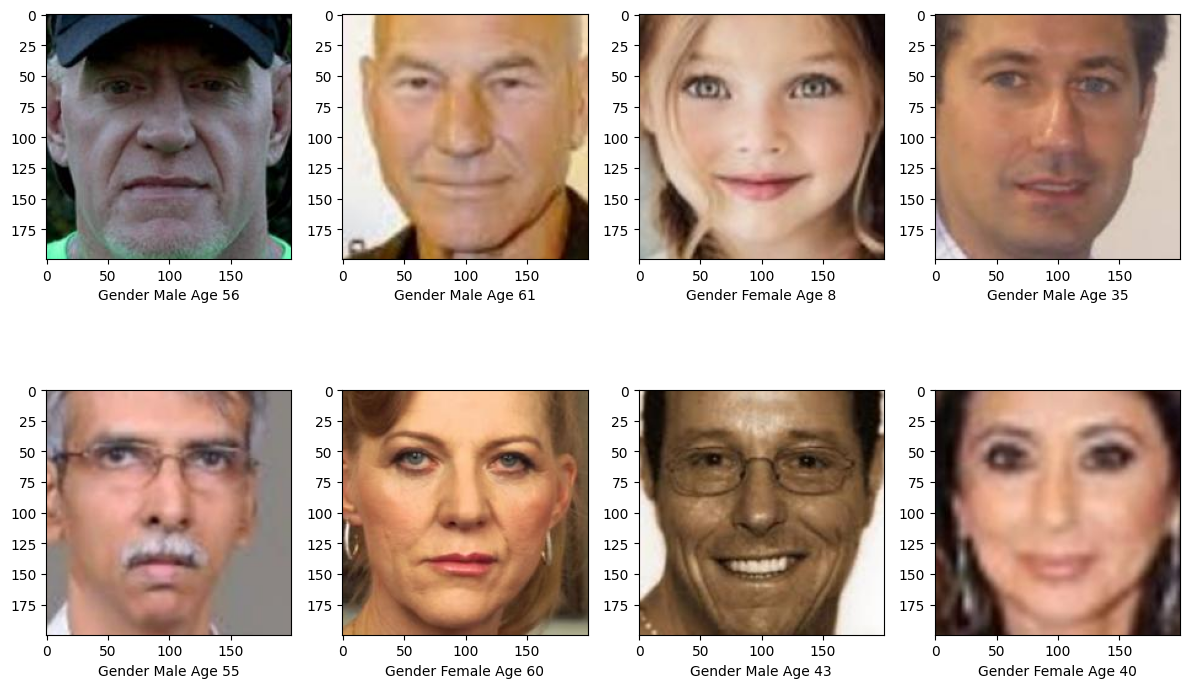

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Set up the figure and subplots
fig, axs = plt.subplots(2, 4, figsize=(12, 8))  # 2 rows, 4 columns

# Flatten the axis array for easy iteration
axs = axs.ravel()

# Loop through each image and display it
for i in range(8):
    index = np.random.randint(23700)  # Randomly select an image index
    path = Images[index]              # Get the path of the current image
    img = mpimg.imread(path)          # Read the image
    axs[i].imshow(img)                # Display the image
    axs[i].set_xlabel(f'Gender {Gender_dict[Ag[index][0]]} Age {Ag[index][1]}')  # Set individual title

# Adjust layout for better spacing between images
plt.tight_layout()
plt.show()

In [7]:
# Check the shape of an image
image = cv2.imread(Images[5000])
print(f'Shape of the image: {image.shape}')

Shape of the image: (200, 200, 3)


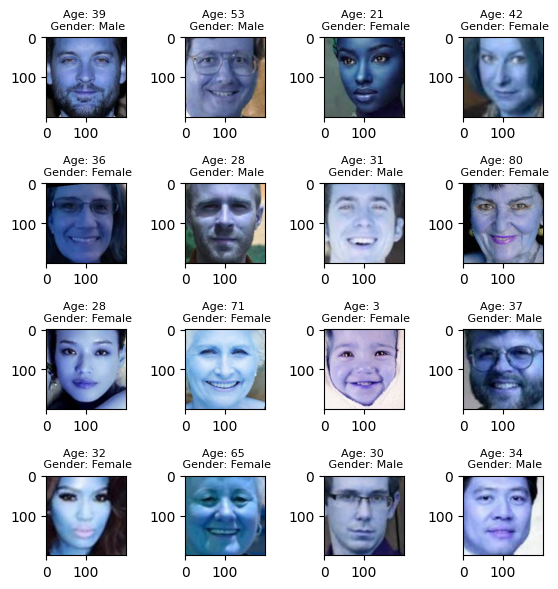

In [95]:
plt.figure(figsize=(6, 6))
arr=np.random.randint(len(Images)-1,size=16)
for i in range(1, 17):
    plt.subplot(4, 4, i)
    n = arr[i-1]
    img = cv2.imread(Images[n])
    plt.imshow(img)
    temp=Images[n].split("\\")[1].split('_')
    plt.title(f"Age: {temp[0]} \n Gender: {Gender_dict[int(temp[1])]}", fontsize=8)
    plt.tight_layout()
plt.show()

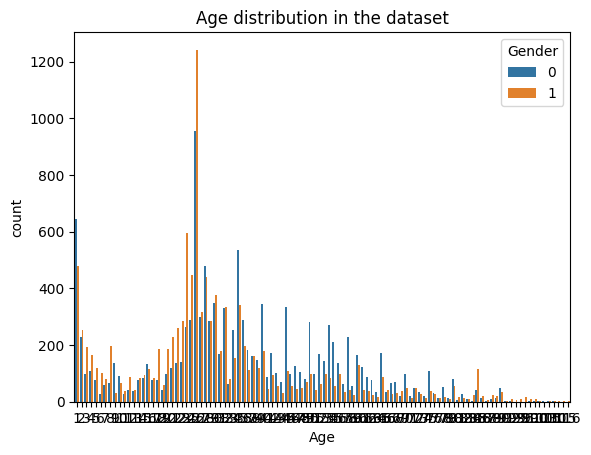

In [8]:
# Ploting the Graph for Genders in the dataset and also Age variations
import seaborn as sns
import pandas as pd
df = pd.DataFrame(Ag, columns=['Gender', 'Age'])
sns.countplot(x='Age', hue='Gender', data=df)
plt.title('Age distribution in the dataset')
plt.show()

# Preprocessing and Featurization

In [9]:
def preprocess_image(path,shape=(64,64)):
    img = cv2.imread(path)
    res_img = cv2.resize(img, shape)
    nom_img = res_img/ 255.0
    return nom_img

In [4]:
# preprocessing each image
Image_F=[]
for pt in tqdm(Images):
    img = preprocess_image(pt,shape=(64,64))
    Image_F.append(img)
image_arrays=np.array(Image_F)
print("Shape of the Image Array", image_arrays.shape)

100%|██████████| 23708/23708 [00:25<00:00, 923.29it/s] 


Shape of the Image Array (23708, 64, 64, 3)


In [5]:
Ag=np.array(Ag)

In [11]:
# Train and Test and Validation split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_arrays, Ag, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [12]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input

# Define input
input_layer = Input(shape=(64, 64, 3))

# Shared layers
x = Conv2D(32, (3, 3), activation='relu')(input_layer)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)

# Output 1: Binary classification (e.g., `sigmoid` activation for binary output)
output_classification = Dense(1, activation='sigmoid', name='binary_output')(x)

# Output 2: Continuous regression (e.g., `linear` activation for continuous output)
output_regression = Dense(1, activation='linear', name='continuous_output')(x)

# Define the model with two outputs
model = Model(inputs=input_layer, outputs=[output_classification, output_regression])

# Compile model with a combination of losses for the two outputs
model.compile(optimizer='adam', 
            loss={'binary_output': 'binary_crossentropy', 'continuous_output': 'mse'},
            metrics={'binary_output': 'accuracy', 'continuous_output': 'mae'})

# Print model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 62, 62,    │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 31, 31,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 29, 29,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 14, 14,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 12, 12,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 6, 6, 128) │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 4608)      │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │  2,359,808 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ binary_output       │ (None, 1)         │        513 │ dropout[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ continuous_output   │ (None, 1)         │        513 │ dropout[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,454,082 (9.36 MB)

 Trainable params: 2,454,082 (9.36 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Checkpoint for the best binary output model
checkpoint_binary = ModelCheckpoint(
    'best_Gender_model.keras',  # Change to .keras
    monitor='val_binary_output_loss', 
    save_best_only=True, 
    verbose=1
)

# Checkpoint for the best continuous output model
checkpoint_continuous = ModelCheckpoint(
    'best_Age_model.keras',  # Change to .keras
    monitor='val_continuous_output_loss', 
    save_best_only=True, 
    verbose=1
)

In [16]:
# Train the model with separate outputs

history = model.fit(
    X_train, 
    {'binary_output': y_train[:, 0], 'continuous_output': y_train[:, 1]},
    epochs=60, 
    validation_data=(X_val, {'binary_output': y_val[:, 0], 'continuous_output': y_val[:, 1]}),
    callbacks=[checkpoint_binary, checkpoint_continuous]
)

Epoch 1/60
474/475 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - binary_output_accuracy: 0.5093 - binary_output_loss: 1.0267 - continuous_output_loss: 491.3382 - continuous_output_mae: 16.8890 - loss: 492.3650
Epoch 1: val_binary_output_loss improved from inf to 0.60323, saving model to best_Gender_model.keras

Epoch 1: val_continuous_output_loss improved from inf to 280.31537, saving model to best_Age_model.keras
475/475 ━━━━━━━━━━━━━━━━━━━━ 34s 64ms/step - binary_output_accuracy: 0.5094 - binary_output_loss: 1.0262 - continuous_output_loss: 490.8821 - continuous_output_mae: 16.8807 - loss: 491.9104 - val_binary_output_accuracy: 0.6784 - val_binary_output_loss: 0.6032 - val_continuous_output_loss: 280.3154 - val_continuous_output_mae: 12.2337 - val_loss: 281.4106
Epoch 2/60
474/475 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - binary_output_accuracy: 0.6270 - binary_output_loss: 0.6653 - continuous_output_loss: 225.2017 - continuous_output_mae: 11.4198 - loss: 225.8670
Epoch 2: val_binary_output_loss did

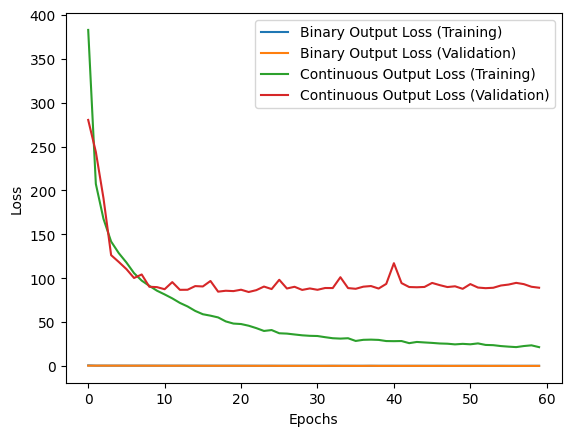

In [17]:
# Plot loss for each output
plt.plot(history.history['binary_output_loss'], label='Binary Output Loss (Training)')
plt.plot(history.history['val_binary_output_loss'], label='Binary Output Loss (Validation)')
plt.plot(history.history['continuous_output_loss'], label='Continuous Output Loss (Training)')
plt.plot(history.history['val_continuous_output_loss'], label='Continuous Output Loss (Validation)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [20]:
model.predict(X_test[6:7])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


[array([[0.8388984]], dtype=float32), array([[27.02232]], dtype=float32)]

In [21]:
y_test[6]

array([ 1, 26])

In [25]:
from sklearn import metrics

# Perform predictions on test data
predictions = model.predict(X_test)
predicted_binary = predictions[0]    # Binary output (index 0)
predicted_continuous = predictions[1]  # Continuous output (index 1)

# Binary output performance
print("Binary Output")
binary_output_true = y_test[:, 0]

# Convert probabilities to binary class (0 or 1)
predicted_binary_class = (predicted_binary > 0.5).astype(int)

# Calculate metrics
accuracy = metrics.accuracy_score(binary_output_true, predicted_binary_class)
precision = metrics.precision_score(binary_output_true, predicted_binary_class)
recall = metrics.recall_score(binary_output_true, predicted_binary_class)
f1 = metrics.f1_score(binary_output_true, predicted_binary_class)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Continuous output performance
print("\nContinuous Output")
continuous_output_true = y_test[:, 1]

# Calculate regression metrics
mse = metrics.mean_squared_error(continuous_output_true, predicted_continuous)
mae = metrics.mean_absolute_error(continuous_output_true, predicted_continuous)
r2 = metrics.r2_score(continuous_output_true, predicted_continuous)

print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"R2 Score: {r2:.4f}")


149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Binary Output
Accuracy: 0.8463
Precision: 0.8649
Recall: 0.8024
F1 Score: 0.8325

Continuous Output
Mean Squared Error: 95.0114
Mean Absolute Error: 7.0630
R2 Score: 0.7606


In [6]:
gender_model = tf.keras.models.load_model('best_Gender_model.keras')
age_model = tf.keras.models.load_model('best_Age_model.keras')

In [114]:
# Make predictions with the binary model
binary_predictions = gender_model.predict(X_test)  # Binary classification output
binary_predictions=np.array(binary_predictions)[0].flatten()
binary_pred_class = (binary_predictions >= 0.5).astype(int) # Ensure predictions are in correct format
binary_output_true = y_test[:, 0]
# Binary Output Performance Metrics
print("Binary Output Performance:")
accuracy = metrics.accuracy_score(binary_output_true, binary_pred_class)
precision = metrics.precision_score(binary_output_true, binary_pred_class)
recall = metrics.recall_score(binary_output_true, binary_pred_class)
f1 = metrics.f1_score(binary_output_true, binary_pred_class)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Make predictions with the continuous model
continuous_predictions = age_model.predict(X_test)  # Continuous output
continuous_predictions = np.array(continuous_predictions[1])  # Ensure predictions are in array format
continuous_output_true = y_test[:, 1]

# Continuous Output Performance Metrics
print("\nContinuous Output Performance:")
mse = metrics.mean_squared_error(continuous_output_true, continuous_predictions)
mae = metrics.mean_absolute_error(continuous_output_true, continuous_predictions)
r2 = metrics.r2_score(continuous_output_true, continuous_predictions)

print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"R2 Score: {r2:.4f}")

149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step
Binary Output Performance:
Accuracy: 0.8496
Precision: 0.8751
Recall: 0.7980
F1 Score: 0.8348
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step

Continuous Output Performance:
Mean Squared Error: 89.9264
Mean Absolute Error: 6.8467
R2 Score: 0.7734


# Model Testing 

In [7]:
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt

Original Gender: Female 
Original Age: 16
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted Gender: Female 
Predicted Age: 22


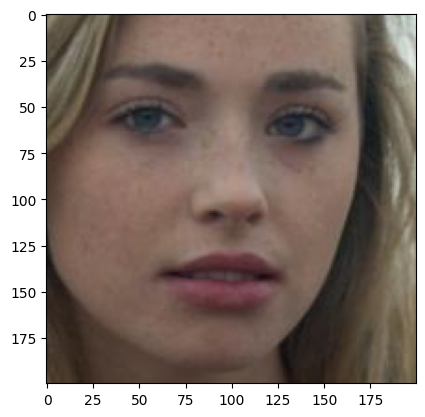

In [13]:
index = 992  # Index to select the image (0,23700)
img = preprocess_image(Images[index])  # Preprocess the selected image

print("Original Gender:", Gender_dict[Ag[index][0]], "\nOriginal Age:", Ag[index][1])

# Reshape the image for the model input
img_reshaped = img.reshape(1, 64, 64, 3)

pre_age = age_model.predict(img_reshaped)  # Age prediction
pre_gender = gender_model.predict(img_reshaped)  # Gender prediction
# Check the structure of pre_gender
pre_gender = np.array(pre_gender)  # Convert to numpy array if it's a list
# Process the gender prediction
predicted_gender_class = (pre_gender >= 0.5).astype(int)[0]  # Get binary class (0 or 1)
predicted_gender_label = Gender_dict[predicted_gender_class[0][0]]  # Map to gender label
# Output predictions
print("Predicted Gender:", predicted_gender_label, "\nPredicted Age:", int(np.round(pre_age[1])[0][0]))  # Output age prediction

# show the image
img=Image.open(Images[index])
plt.imshow(img);

In [26]:
def preprocess_image(path, shape=(64, 64)):
    img = cv2.imread(path)
    if img is None:
        raise ValueError("Image not loaded. Check the file path and format.")
    res_img = cv2.resize(img, shape)
    norm_img = res_img / 255.0
    return norm_img

In [39]:
def predict_AGEN(image_path):
    img = preprocess_image(image_path)  # Preprocess the selected image

    # Reshape the image for the model input
    img_reshaped = img.reshape(1, 64, 64, 3)

    pre_age = age_model.predict(img_reshaped)  # Age prediction
    pre_gender = gender_model.predict(img_reshaped)  # Gender prediction
    # Check the structure of pre_gender
    pre_gender = np.array(pre_gender)  # Convert to numpy array if it's a list
    # Process the gender prediction
    predicted_gender_class = (pre_gender >= 0.5).astype(int)[0]  # Get binary class (0 or 1)
    predicted_gender_label = Gender_dict[predicted_gender_class[0][0]]  # Map to gender label
    # Output predictions
    print("Predicted Gender:", predicted_gender_label, "\nPredicted Age:", int(np.round(pre_age[1])[0][0]))  # Output age prediction

    # show the image
    img=Image.open(image_path)
    plt.imshow(img);
    return 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted Gender: Female 
Predicted Age: 12


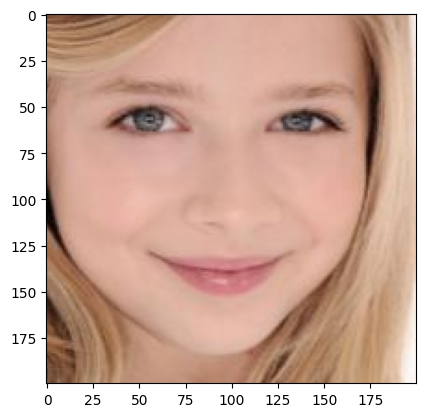

In [40]:
predict_AGEN('E:\jupyter notebook\machine learning\machine learning\mlprojects\Age and Gender recognition\dataface\kt.jpg')

In [31]:
import pandas as pd

In [47]:
def predict_in_df(folder):
    facepaths=[]
    result=[]
    for sub_img in os.listdir(folder):
        sub_path=os.path.join(folder,sub_img)
        facepaths.append(sub_path)
        img = preprocess_image(sub_path)  # Preprocess the selected image
        # Reshape the image for the model input
        img_reshaped = img.reshape(1, 64, 64, 3)
        pre_age = age_model.predict(img_reshaped,verbose=0)  # Age prediction
        pre_gender = gender_model.predict(img_reshaped,verbose=0)  # Gender prediction
        # Check the structure of pre_gender
        pre_gender = np.array(pre_gender)  # Convert to numpy array if it's a list
        # Process the gender prediction
        predicted_gender_class = (pre_gender >= 0.5).astype(int)[0]  # Get binary class (0 or 1)
        gender = Gender_dict[predicted_gender_class[0][0]]  # Map to gender label
        age=int(np.round(pre_age[1])[0][0])
        if age >120:
            age-=20
        # append the data into the df
        result.append({"Image Path":sub_path,"Age":age,"Gender":gender})

    return pd.DataFrame(result)

In [51]:
Age_gender_dataFrame=predict_in_df('faces')

In [52]:
Age_gender_dataFrame

,Image Path,Age,Gender
0,faces\A.jpg,25,Female
1,faces\akshu.jpg,32,Male
2,faces\am.jpg,56,Male
3,faces\chotu.jpg,13,Male
4,faces\cris.jpg,31,Female
5,faces\d.jpg,32,Female
6,faces\mihir.jpg,58,Male
7,faces\nikita.jpg,52,Male
8,faces\nikita2.jpg,51,Female
9,faces\nilesh.jpg,66,Male


Text(0.5, 1.0, 'Age:65\nGender:Male')

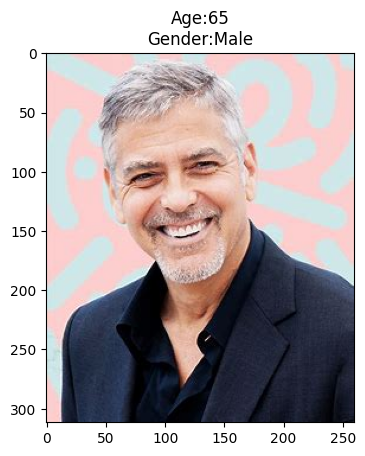

In [88]:
i=29
plt.imshow(Image.open(Age_gender_dataFrame['Image Path'][i]));
plt.title(f"Age:{Age_gender_dataFrame['Age'][i]}\nGender:{Age_gender_dataFrame['Gender'][i]}")